In [1]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

## Model Settings

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_CLASSES = 2

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

## Load and Prepare Data

In [5]:
data_loc = "../process/processed_data/drain/"

In [6]:
# Train sets
train_data = np.load('{}x_train.npy'.format(data_loc))
read_train_labels = pd.read_csv('{}y_train.csv'.format(data_loc))
train_labels = read_train_labels['Label'] == 'Anomaly'
train_labels = train_labels.astype(int)

# Test sets
test_data = np.load('{}x_test.npy'.format(data_loc))
read_test_labels = pd.read_csv('{}y_test.csv'.format(data_loc))
test_labels = read_test_labels['Label'] == 'Anomaly'
test_labels = test_labels.astype(int)

# Split the Train dataset into train and validation dataset
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2)

In [7]:
# check the train set & the validation set
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

print("train data shape")
print(train_data.shape)
print(train_labels.shape)
print("val data shape")
print(val_data.shape)
print(val_labels.shape)

# distribution
print(len(train_labels))
anom = train_labels[train_labels > 0]
norm = train_labels[train_labels == 0]
print(anom.shape)
print(norm.shape)
print(len(anom)/len(train_labels))

# check the test set #distribution
print(len(test_labels))
anom = test_labels[test_labels > 0]
norm = test_labels[test_labels == 0]
print(anom.shape)
print(norm.shape)

print(len(anom)/len(test_labels))

train data shape
(315602, 16, 46)
(315602,)
val data shape
(78901, 16, 46)
(78901,)
315602
(9881,)
(305721,)
0.03130842009873195
120537
(1983,)
(118554,)
0.016451380074168097


In [8]:
class logDataset(Dataset):
    """Log Anomaly Features Dataset"""
    
    def __init__(self, data_vec, labels=None):
        self.X = data_vec
        self.y = labels
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        data_matrix = self.X[idx]
        
        if not self.y is None:
            return(data_matrix, self.y[idx])
        else:
            return data_matrix

In [9]:
# padding
train_data = torch.tensor(train_data, dtype=torch.float32)
train_data = F.pad(input=train_data, pad=(1, 1, 1, 1), mode='constant', value=0) # pad all sides with 0s
train_data = np.expand_dims(train_data, axis=1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_data = F.pad(input=test_data, pad=(1, 1, 1, 1), mode='constant', value=0)
test_data = np.expand_dims(test_data, axis=1)
val_data = torch.tensor(val_data, dtype=torch.float32)
val_data = F.pad(input=val_data, pad=(1, 1, 1, 1), mode='constant', value=0)
val_data = np.expand_dims(val_data, axis=1)

In [10]:
# pass datasets into the custom dataclass
train_dataset = logDataset(train_data, labels = train_labels)
test_dataset = logDataset(test_data, labels = test_labels)
val_dataset = logDataset(val_data, labels = val_labels)

In [11]:
# use DataLoader class
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=0, # couldn't use workers https://github.com/fastai/fastbook/issues/85
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=0,
                         shuffle=False)

val_loader = DataLoader(dataset=val_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=0,
                         shuffle=False)


# Checking the dataset
for data, labels in train_loader:  
    print('Matrix batch dimensions:', data.shape)
    print('Matrix label dimensions:', labels.shape)
    break

# Checking the dataset
for data, labels in test_loader:  
    print('Matrix batch dimensions:', data.shape)
    print('Matrix label dimensions:', labels.shape)
    break
    
# Checking the dataset
for data, labels in val_loader:  
    print('Matrix batch dimensions:', data.shape)
    print('Matrix label dimensions:', labels.shape)
    break

Matrix batch dimensions: torch.Size([128, 1, 18, 48])
Matrix label dimensions: torch.Size([128])
Matrix batch dimensions: torch.Size([128, 1, 18, 48])
Matrix label dimensions: torch.Size([128])
Matrix batch dimensions: torch.Size([128, 1, 18, 48])
Matrix label dimensions: torch.Size([128])


## Setup Model

In [12]:
# Check that the train loader works correctly
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [13]:
##########################
### MODEL
##########################

class LeNet5(nn.Module):

    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=2),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=2),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(

            nn.Linear(1056, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas


In [14]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train Model

In [15]:
batch_cost = []
train_accuracy_list = []
val_accuracy_list = []

def compute_accuracy(model, data_loader, device):
    y_hats = []
    y_acts = []
    for i, (inputs, targets) in enumerate(data_loader):
        yhat = model(inputs)[-1].cpu().detach().numpy().round()
        yhat = np.argmax(yhat, axis=1)
        y_hats.append(yhat)
        y_acts.append(list(targets.cpu().detach().numpy()))
    
    y_hats = [item for sublist in y_hats for item in sublist]
    y_acts = [item for sublist in y_acts for item in sublist]
    return accuracy_score(y_acts, y_hats)

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE, dtype=torch.long)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        batch_cost.append(cost)#record the cost of the batch
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_accuracy = compute_accuracy(model, train_loader, device=DEVICE)
        val_accuracy = compute_accuracy(model, val_loader, device=DEVICE)
        #record the accuracy
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        print('Epoch: %03d/%03d | Train: %.3f%%   | Val: %.3f%%' % (
              epoch+1, NUM_EPOCHS, train_accuracy, val_accuracy))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/2466 | Cost: 0.6218
Epoch: 001/010 | Batch 0050/2466 | Cost: 0.0628
Epoch: 001/010 | Batch 0100/2466 | Cost: 0.0074
Epoch: 001/010 | Batch 0150/2466 | Cost: 0.0061
Epoch: 001/010 | Batch 0200/2466 | Cost: 0.0826
Epoch: 001/010 | Batch 0250/2466 | Cost: 0.0027
Epoch: 001/010 | Batch 0300/2466 | Cost: 0.0009
Epoch: 001/010 | Batch 0350/2466 | Cost: 0.0003
Epoch: 001/010 | Batch 0400/2466 | Cost: 0.0002
Epoch: 001/010 | Batch 0450/2466 | Cost: 0.0007
Epoch: 001/010 | Batch 0500/2466 | Cost: 0.0001
Epoch: 001/010 | Batch 0550/2466 | Cost: 0.0208
Epoch: 001/010 | Batch 0600/2466 | Cost: 0.0001
Epoch: 001/010 | Batch 0650/2466 | Cost: 0.0040
Epoch: 001/010 | Batch 0700/2466 | Cost: 0.0004
Epoch: 001/010 | Batch 0750/2466 | Cost: 0.0003
Epoch: 001/010 | Batch 0800/2466 | Cost: 0.0001
Epoch: 001/010 | Batch 0850/2466 | Cost: 0.0003
Epoch: 001/010 | Batch 0900/2466 | Cost: 0.0612
Epoch: 001/010 | Batch 0950/2466 | Cost: 0.0002
Epoch: 001/010 | Batch 1000/2466 | Cost:

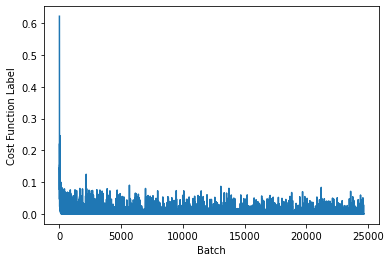

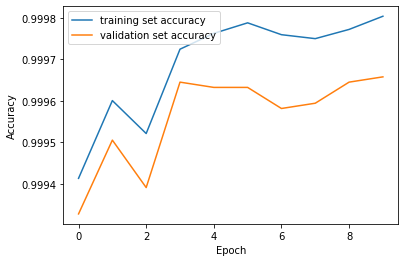

In [16]:
# Plot the training process cost functions
batch_cost_cpu = [i.cpu().detach().numpy() for i in batch_cost]

plt.plot(range(len(batch_cost_cpu)), batch_cost_cpu)
plt.ylabel('Cost Function Label')
plt.xlabel('Batch')
plt.show()

plt.plot(range(len(train_accuracy_list)), train_accuracy_list, label="training set accuracy")
plt.plot(range(len(val_accuracy_list)), val_accuracy_list, label="validation set accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Evaluation

In [17]:
# Evaluate metrics on the test set
y_hats = []
y_acts = []
counter = 0
for i, (inputs, targets) in enumerate(test_loader):
    yhat = model(inputs)[-1].cpu().detach().numpy().round()
    yhat = np.argmax(yhat, axis=1)
    y_hats.append(yhat)
    y_acts.append(list(targets.cpu().detach().numpy()))
    counter += 1

y_hats = [item for sublist in y_hats for item in sublist]
y_acts = [item for sublist in y_acts for item in sublist]

print("=====TEST SET METRICS:=====")
accuracy = accuracy_score(y_acts, y_hats)
print("accuracy :", accuracy)
precision = precision_score(y_acts, y_hats)
print("precision :", precision)
recall = recall_score(y_acts, y_hats)
print("recall :", recall)

=====TEST SET METRICS:=====
accuracy : 0.999900445506359
precision : 1.0
recall : 0.9939485627836612


In [18]:
test_ys = pd.DataFrame(list(zip(y_acts, y_hats)), columns=["y_true", "y_pred"])

print("=====TEST SET PERFORMANCE:=====")
print("anomalous:\n")
test_anomalous = test_ys[test_ys["y_true"]==1]
print("number of anomalies in the test set:", len(test_anomalous))
correct_anomalous = test_anomalous[test_anomalous["y_true"] == test_anomalous["y_pred"]]
print("number of anomalies correctly identified", len(correct_anomalous))
incorrect_anomalous = test_anomalous[test_anomalous["y_true"] != test_anomalous["y_pred"]]
print("number of anomalies incorrectly identified", len(incorrect_anomalous))

print("\nnormal:\n")
test_normals = test_ys[test_ys["y_true"]==0]
print("number of normals in the test set:", len(test_normals))
correct_normal = test_normals[test_normals["y_true"] == test_normals["y_pred"]]
print("number of normals correctly identified", len(correct_normal))
incorrect_normal = test_normals[test_normals["y_true"] != test_normals["y_pred"]]
print("number of normals incorrectly identified", len(incorrect_normal))

=====TEST SET PERFORMANCE:=====
anomalous:

number of anomalies in the test set: 1983
number of anomalies correctly identified 1971
number of anomalies incorrectly identified 12

normal:

number of normals in the test set: 118554
number of normals correctly identified 118554
number of normals incorrectly identified 0


In [19]:
# Evaluate metrics on the train set
y_hats = []
y_acts = []
counter = 0
for i, (inputs, targets) in enumerate(train_loader):
    yhat = model(inputs)[-1].cpu().detach().numpy().round()
    yhat = np.argmax(yhat, axis=1)
    y_hats.append(yhat)
    y_acts.append(list(targets.cpu().detach().numpy()))
    counter += 1

y_hats = [item for sublist in y_hats for item in sublist]
y_acts = [item for sublist in y_acts for item in sublist]

print("=====TRAIN SET METRICS:=====")
accuracy = accuracy_score(y_acts, y_hats)
print("accuracy :", accuracy)
precision = precision_score(y_acts, y_hats)
print("precision :", precision)
recall = recall_score(y_acts, y_hats)
print("recall :", recall)

=====TRAIN SET METRICS:=====
accuracy : 0.9998035500408743
precision : 0.995558695871606
recall : 0.9981783220321829


In [20]:
train_ys = pd.DataFrame(list(zip(y_acts, y_hats)), columns=["y_true", "y_pred"])

print("=====TRAIN SET PERFORMANCE:=====")
print("anomalous:\n")
train_anomalous = train_ys[train_ys["y_true"]==1]
print("number of anomalies in the train set:", len(train_anomalous))
correct_anomalous = train_anomalous[train_anomalous["y_true"] == train_anomalous["y_pred"]]
print("number of anomalies correctly identified", len(correct_anomalous))
incorrect_anomalous = train_anomalous[train_anomalous["y_true"] != train_anomalous["y_pred"]]
print("number of anomalies incorrectly identified", len(incorrect_anomalous))

print("\nnormal:\n")
train_normals = train_ys[train_ys["y_true"]==0]
print("number of normals in the train set:", len(train_normals))
correct_normal = train_normals[train_normals["y_true"] == train_normals["y_pred"]]
print("number of normals correctly identified", len(correct_normal))
incorrect_normal = train_normals[train_normals["y_true"] != train_normals["y_pred"]]
print("number of normals incorrectly identified", len(incorrect_normal))

=====TRAIN SET PERFORMANCE:=====
anomalous:

number of anomalies in the train set: 9881
number of anomalies correctly identified 9863
number of anomalies incorrectly identified 18

normal:

number of normals in the train set: 305721
number of normals correctly identified 305677
number of normals incorrectly identified 44
